# Differentiating Rollout Trajectories
Bayesian Optimization can be described entirely in 7 steps, adding nuance when necessary:
1. Gather initial samples
2. Initialize our model
3. Get the acquisition function $\alpha(x)$
4. Optimize the acquisition function
5. Sample new data based on results from the optimization of $\alpha(x)$ and update model
6. Repeat until budget is exhausted
7. Make final recommendation

post ~ prior * likelikhood

### Desiderata
* Figure out how to update the model by reconditioning the current model on new observations
* Construct an API that leverages our computing framework while remaining free of dogmatism when it comes to implementing each step
* Elaborate on the nuances of incorporating rollout into the Bayesian Optimization algorithm.

In [1]:
using CovarianceFunctions
using GaussianDistributions
using LinearAlgebra
using Optim
using Plots

import Distributions

In [2]:
pyplot()
CF = CovarianceFunctions

CovarianceFunctions

## Objective Function
Here, our objective function is known, but in practice, it usually isn't. We'll be using the d-dimensional [Ackley](https://www.sfu.ca/~ssurjano/ackley.html) function as our objective. Here, we'll let $d=2$.
$$
f(\textbf{x}) = -a \exp \left( -b \sqrt{\frac{1}{d}\sum\limits_{i=1}^d x_{i}^2} \right) - \exp \left( \frac{1}{d} \sum\limits_{i=1}^d \cos(cx_i) \right) + a + \exp(1)
$$
where the recommended variable values are: $a = 20$, $b = 0.2$ and $c=2\pi$.
Also note, the input domain is usually evaluated on the hypercube $x_i \in [-32.768, 32.768]$, for all $i = 1,...,d$, although it may also be restricted to a smaller domain.

In [4]:
function ackley(x; a=20, b=0.2, c=2π, σnoise=0.0)
    term1 = term2 = 0.0
    term3 = a
    term4 = exp(1)
    d = length(x)
    
    for i in 1:d
        term1 += x[i] * x[i]
        term2 += cos(c*x[i])
    end
    
    term1 = -a*exp(-b * √(1/d * term1))
    term2 = -exp(1/d * term2)
    
    return -(term1 + term2 + term3 + term4 + σnoise^2*randn())
end

ackley (generic function with 1 method)

## Step 1: Gathering of Initial Samples
Suppose that we've observed our rather noisy process and are able to collect n sample points, due to resource constraints, and we wish to make an intelligent query of our process at a later date. First, we'll gather our noisy observations.

$$
f(\textbf{x}) = -a \exp \left( -b \sqrt{\frac{1}{d}\sum\limits_{i=1}^d x_{i}^2} \right) - \exp \left( \frac{1}{d} \sum\limits_{i=1}^d \cos(cx_i) \right) + a + \exp(1) + \epsilon
$$
where $\epsilon \sim \mathcal{N}(0, \sigma_{n}^2)$.

We then collect our initial sample points, $x_i$ for all $i = 1,...,n$ into our matrix:
$$
X = 
\begin{bmatrix}
    \vert & & \vert \\
    x_1   & ... & x_n   \\
    \vert & & \vert
\end{bmatrix}
$$

For our purposes, we'll let $n_{init} = 3$ and sample $n_{init}$ points on the $d$-dimensional hypercube per detailed earlier.

In [28]:
σnoise = 0.1
bound = 32.768
n_init = 60
dim = 1
X_init = vec((2bound)rand(dim, n_init) .- bound);
X_init = -bound:(2*bound/n_init):bound
Y_init = ackley.(X_init; σnoise);
# for i = 1:n_init
#    Y_init[i] = ackley(X_init[:, i]; σnoise=σnoise) 
# end

61-element Array{Float64,1}:
 -21.574111862161025
 -22.039488683657382
 -22.247008796000234
 -22.28196651824417
 -22.197687482745273
 -21.932733081410152
 -21.382143967706796
 -20.534921614559984
 -19.88575687598569
 -20.002716513001452
 -20.702060244813126
 -21.364249758539206
 -21.73741673954569
   ⋮
 -21.37856133002921
 -20.679224535893844
 -19.99364469045591
 -19.876621048489575
 -20.529138673369726
 -21.343596711783462
 -21.91958371342775
 -22.20796342885538
 -22.30695666526124
 -22.25134086412989
 -22.047796286120345
 -21.56059938514267

## Step 2: Initializing Our Model
Our model of choice is a Gaussian process, which is completely defined by its mean function and covariance function.
$$
\begin{aligned}
m(\textbf{x}) &= \mathbb{E}[f(\textbf{x})],\\
k(\textbf{x}, \textbf{x'}) &= \mathbb{E}[(f(\textbf{x}) - m(\textbf{x}))(f(\textbf{x'}) - m(\textbf{x'}))]
\end{aligned}
$$
and we write the Gaussian process as
$$
f(\textbf{x}) \sim \mathcal{GP}(m(\textbf{x}), k(\textbf{x}, \textbf{x'}))
$$

Our covariance function of choice will be the squared exponential kernel, where the hyperparameters must be learned. For the time being, we'll set them manually.
<hr>
Below, we make use of some interesting developing packages, so further details are required when tracing out our computation.

In [29]:
ℓ = .5 # set to 0.5 for toy example
μ(x) = 0
Σ(x, y) = CF.Lengthscale(CF.EQ(), ℓ)(x, y)
# Σ(x, y) = CF.Lengthscale(CF.Matern(.5), ℓ)(x, y)
GP = Gaussian(μ, Σ)
σnoise = 0.01
CGP = GP | (X_init, Y_init, σnoise); # when conditioning, x_init must be a column vector

# for i in 1:n_init
#     CGP = GP | (X_init[:, i], Y_init[i], σnoise)
# end

## Step 3: Get the Acquisition Function $\alpha(\textbf{x})$
Here, our acquisition function will be expected improvement, which is defined as:

$$
EI(\textbf{x}) = \mathbb{E} [max(f(\textbf{x}) - f(\textbf{x}^+), 0)]
$$

where $f(\textbf{x}^+)$ is the value of the best sample so far and $\textbf{x}^+$ is the location of that sample i.e. $\textbf{x}^+ = argmax_{x_{i} \in x_{1:n}}f(\textbf{x}_i)$. The expected improvement can be evaluated analytically under the GP model:

$$
EI(\textbf{x}) =
\left\{
\begin{array}{ll}
      (\mu(\textbf{x}) - f(\textbf{x}^+) - \xi)\Phi(Z) + \sigma(\textbf{x})\phi(Z) & \sigma(\textbf{x}) \gt 0 \\
      0 & \sigma(\textbf{x}) = 0 \\
\end{array} 
\right.
$$

where

$$
Z =
\left\{
\begin{array}{ll}
      \frac{\mu(\textbf{x}) - f(\textbf{x}^+) - \xi}{\sigma(\textbf{x})} & \sigma(\textbf{x}) \gt 0 \\
      0 & \sigma(\textbf{x}) = 0 \\
\end{array} 
\right.
$$

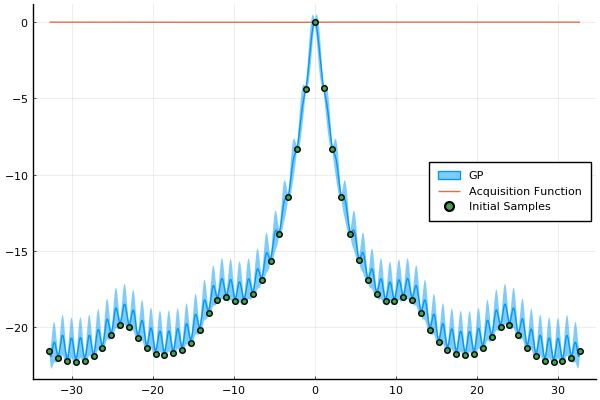

In [31]:
# First, let's grab x+ and f(x+)
fbest, fbest_ndx = findmax(Y_init)
xbest = X_init[fbest_ndx]

# Let's evaluate EI over our domain
grid = collect(-bound:.01:bound)
μ̂ = mean(CGP)
σ̂ = std(CGP)

function z(x, f⁺; ξ=0.1)
    return σ̂(x) > 0 ? (μ̂(x) - f⁺ - ξ) / σ̂(x) : 0
end

function ei(x, f⁺; ξ=0.1)
    z_eval = z(x, f⁺; ξ=ξ)
    normal = Distributions.Normal()
    normal_cdf_at_z = Distributions.cdf(normal, z_eval)
    normal_pdf_at_z = Distributions.pdf(normal, z_eval)
    σ̂eval = σ̂(x)
    
    return σ̂eval > 0 ? (μ̂(x) - f⁺ - ξ) * normal_cdf_at_z + σ̂(x)*normal_pdf_at_z : 0
end

# Now to plot the response surface
# We want to maximize expected improvement, but our optimization library deals primarily in
# minimization, therefore we seek to minimize the negation of expected improvement
plot(grid, μ̂.(grid), ribbon=2σ̂.(grid), label="GP")
plot!(grid, -ei.(grid, fbest; ξ=.1), label="Acquisition Function")
# plot!(grid, ackley.(grid), label="Ackley Function")
# plot!(grid, μ̂.(grid), ribbon=2σ̂.(grid), label="GP") # also plot multiple draws from GP
Plots.scatter!(X_init, Y_init, label="Initial Samples")

## Step 4: Optimize the Acquisition Function
Now that we have a functional handle on our acquisition function, we'll use this to propose our next sample location.

In [23]:
# Is it worthwhile keeping track of the best to date?
ei_fbest(x) = -ei(x[1], fbest) # want some auto differentiation here
result = optimize(ei_fbest, [0.0], LBFGS())
xnew = Optim.minimizer(result)
println("Minimum: $(Optim.minimum(result))\nMinimizer: $(Optim.minimizer(result))")

Minimum: -2.772800620088575e-48
Minimizer: [0.0]


## Step 5: Sample New Data Based on Results from the Optimization of $\alpha(x)$ and Update Model
Now we want to evaluate the objective function at our new proposed location.

In [16]:
push!(X_init, xnew[1])
push!(Y_init, ackley(xnew[1]; σnoise))

301-element Array{Float64,1}:
 -22.27258061196509
 -17.496827175598902
 -13.482078410834532
  -4.39021483032714
 -22.238391058990963
 -17.882817224558604
 -20.80784288272934
 -20.336880029805034
 -20.37997483739859
 -12.491678162514818
 -19.909265617706385
 -20.04051128096096
 -20.210434380143756
   ⋮
 -18.109233710137776
 -14.127671559266206
 -15.960956989235566
 -20.462122480517817
 -22.268056073117165
 -21.41405550659043
 -21.664813960876835
 -22.196456534977468
 -20.09950594890019
 -21.910833783096724
 -21.155178349320856
   3.24767380990712e-5

In [303]:
# Update our model
# Replot acquisition, samples and objective

In [332]:
sample(CGP, 1)

LoadError: MethodError: no method matching sample(::Gaussian{GaussianDistributions.ConditionalMean{Gaussian{typeof(μ),typeof(Σ)},Array{Float64,1},Array{Float64,1}},GaussianDistributions.ConditionalKernel{Float64,typeof(Σ),Array{Float64,1},LazyInverse.Inverse{Float64,WoodburyIdentity.Woodbury{Float64,Diagonal{Float64,Array{Float64,1}},Array{Float64,2},LazyInverse.Inverse{Float64,Cholesky{Float64,Array{Float64,2}}},Adjoint{Float64,Array{Float64,2}},Int64,Tuple{Float64,Float64}}}}}, ::Int64)
Closest candidates are:
  sample(!Matched::AbstractArray, ::Integer; replace, ordered) at /Users/jamosa/.julia/packages/StatsBase/EA8Mh/src/sampling.jl:461
  sample(!Matched::Gaussian{var"#s21",var"#s20"} where var"#s20"<:Cholesky where var"#s21"<:(AbstractArray{T,1} where T), ::Int64; tol) at /Users/jamosa/.julia/packages/GaussianDistributions/AUZIQ/src/sample.jl:24
  sample(!Matched::Gaussian{var"#s21",var"#s20"} where var"#s20"<:CholeskyPivoted where var"#s21"<:(AbstractArray{T,1} where T), ::Int64; tol) at /Users/jamosa/.julia/packages/GaussianDistributions/AUZIQ/src/sample.jl:27
  ...

In [339]:
sample(Gaussian())

0.33496302188486926

In [334]:
CGP

Gaussian{GaussianDistributions.ConditionalMean{Gaussian{typeof(μ),typeof(Σ)},Array{Float64,1},Array{Float64,1}},GaussianDistributions.ConditionalKernel{Float64,typeof(Σ),Array{Float64,1},LazyInverse.Inverse{Float64,WoodburyIdentity.Woodbury{Float64,Diagonal{Float64,Array{Float64,1}},Array{Float64,2},LazyInverse.Inverse{Float64,Cholesky{Float64,Array{Float64,2}}},Adjoint{Float64,Array{Float64,2}},Int64,Tuple{Float64,Float64}}}}}(GaussianDistributions.ConditionalMean{Gaussian{typeof(μ),typeof(Σ)},Array{Float64,1},Array{Float64,1}}(Gaussian{typeof(μ),typeof(Σ)}(μ, Σ), [17.584579592225538, -7.075117479705469, -25.208144779417097, 28.68964575520068, -18.714588423050024], [-19.713076157940634, -14.018902153501159, -17.77878035309405, -19.934906450951814, -17.927134533869236]), GaussianDistributions.ConditionalKernel{Float64,typeof(Σ),Array{Float64,1},LazyInverse.Inverse{Float64,WoodburyIdentity.Woodbury{Float64,Diagonal{Float64,Array{Float64,1}},Array{Float64,2},LazyInverse.Inverse{Float64,C

In [25]:
cholesky(CGP.Σ)

LoadError: MethodError: no method matching cholesky(::GaussianDistributions.ConditionalKernel{Float64,typeof(Σ),Array{Float64,1},LazyInverse.Inverse{Float64,WoodburyIdentity.Woodbury{Float64,Diagonal{Float64,Array{Float64,1}},Array{Float64,2},LazyInverse.Inverse{Float64,Cholesky{Float64,Array{Float64,2}}},Adjoint{Float64,Array{Float64,2}},Int64,Tuple{Float64,Float64}}}})
Closest candidates are:
  cholesky(!Matched::Union{Hermitian{Complex{T},SparseArrays.SparseMatrixCSC{Complex{T},Int64}}, Hermitian{T,SparseArrays.SparseMatrixCSC{T,Int64}}, Symmetric{T,SparseArrays.SparseMatrixCSC{T,Int64}}, SparseArrays.SparseMatrixCSC{T,Ti} where Ti<:Integer, SparseArrays.SparseMatrixCSC{Complex{T},Ti} where Ti<:Integer}; kws...) where T<:Real at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/SuiteSparse/src/cholmod.jl:1458
  cholesky(!Matched::Union{StridedArray{T, 2} where T, Union{Hermitian{var"#s823",var"#s822"}, Hermitian{Complex{var"#s823"},var"#s822"}, Symmetric{var"#s823",var"#s822"}} where var"#s822"<:(StridedArray{T, 2} where T) where var"#s823"<:Real}) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/LinearAlgebra/src/cholesky.jl:344
  cholesky(!Matched::Union{StridedArray{T, 2} where T, Union{Hermitian{var"#s821",var"#s820"}, Hermitian{Complex{var"#s821"},var"#s820"}, Symmetric{var"#s821",var"#s820"}} where var"#s820"<:(StridedArray{T, 2} where T) where var"#s821"<:Real}, !Matched::Val{false}; check) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/LinearAlgebra/src/cholesky.jl:344
  ...

In [32]:
factorize(Gaussian(μ, Σ), tol=1e-5)

LoadError: MethodError: no method matching factorize(::Gaussian{typeof(μ),typeof(Σ)}; tol=1.0e-5)
Closest candidates are:
  factorize(!Matched::StridedArray{T, 2}) where T at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/LinearAlgebra/src/dense.jl:1207 got unsupported keyword argument "tol"
  factorize(!Matched::Adjoint) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/LinearAlgebra/src/dense.jl:1283 got unsupported keyword argument "tol"
  factorize(!Matched::Transpose) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/LinearAlgebra/src/dense.jl:1284 got unsupported keyword argument "tol"
  ...